# DRS Example

This code tests the proof of Douglas--Rachford splitting methods, introduced in Proposition 3.1 of
"Exact worst-case convergence rates for Douglas--Rachford and Davis--Yin splitting methods"
by Edward Duc Hien Nguyen, Jaewook J. Suh, Xin Jiang, Shiqian Ma (2025).

The implementation in terms of the PEP is based on the PDHG implementation done in the paper 
"Interpolation Conditions for Linear Operators and Applications to Performance Estimation
Problems" by Nizar Bousselmi, Julien M. Hendrickx, François Glineur (2023).

## Import the required libraries

In [ ]:
"""
This code tests the proof of Douglas--Rachford splitting methods, introduced in Proposition 3.1 of
"Exact worst-case convergence rates for Douglas--Rachford and Davis--Yin splitting methods"
by Edward Duc Hien Nguyen, Jaewook J. Suh, Xin Jiang, Shiqian Ma (2025).

The implementation in terms of the PEP is based on the PDHG implementation done in the paper 
"Interpolation Conditions for Linear Operators and Applications to Performance Estimation
Problems" by Nizar Bousselmi, Julien M. Hendrickx, François Glineur (2023).
"""

import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
from IPython.display import display

## Define the functions

In [2]:
f = pf.ConvexFunction(is_basis=True, tags=["f"])
g = pf.ConvexFunction(is_basis=True, tags=["g"])
h = (f + g).add_tag("h")

## Write a function to return the PEPContext associated with DRS

In [ ]:
def make_ctx_drs(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_drs = pf.PEPContext(ctx_name).set_as_current()

    # Declare the initial points.
    x_0 = pf.Vector(is_basis=True, tags=["x_0"])
    u_0 = pf.Vector(is_basis=True, tags=["u_0"])

    # Declare the points used in the primal-dual gap function.
    _ = pf.Vector(is_basis=True, tags=["x_{{tilde}}"])  # ty: ignore
    u_tilde = pf.Vector(is_basis=True, tags=["u_{{tilde}}"])

    # Moving Average
    x_sum = pf.Vector.zero()
    u_sum = pf.Vector.zero()

    x = x_0
    u = u_0

    for i in range(N):
        x_old = x

        x = f.proximal_step(x - stepsize * u, stepsize).add_tag(f"x_{i + 1}")
        f.grad(x).add_tag(f"grad_f({x.tag})")

        t = u + 1 / stepsize * (2 * x - x_old)
        p = g.proximal_step(stepsize * t, stepsize)
        p.add_tag(f"p_{i + 1}")

        u = t - 1 / stepsize * p
        u.add_tag(f"u_{i + 1}")

        x_sum = x_sum + x
        u_sum = u_sum + u

    _ = (x_sum / float(N)).add_tag("x_{{avg}}")  # ty: ignore
    u_avg = (u_sum / float(N)).add_tag("u_{{avg}}")

    # Define p_tilde and p_avg such that u_tilde \in \partial g(p_tilde) and u_avg \in \partial g(u_avg)
    p_tilde = pf.Vector(is_basis=True, tags=["p_{{tilde}}"])
    p_avg = pf.Vector(is_basis=True, tags=["p_{{avg}}"])
    g.add_point_with_grad_restriction(p_tilde, u_tilde)
    g.add_point_with_grad_restriction(p_avg, u_avg)
    return ctx_drs

## Write a function to return the PEPBuilder for DRS 

In [4]:
def make_pb_drs(
    ctx: pf.PEPContext, stepsize: pf.Parameter, init_distance: pf.Parameter
) -> pf.PEPBuilder:
    x_0 = ctx["x_0"]
    x_tilde = ctx["x_{{tilde}}"]
    x_avg = ctx["x_{{avg}}"]

    u_0 = ctx["u_0"]
    u_tilde = ctx["u_{{tilde}}"]
    u_avg = ctx["u_{{avg}}"]

    p_tilde = ctx["p_{{tilde}}"]
    p_avg = ctx["p_{{avg}}"]

    pb = pf.PEPBuilder(ctx_plt)

    # Initial Condition
    pb.add_initial_constraint(
        ((1.0 / stepsize) * (x_0 - x_tilde) ** 2 + stepsize * (u_0 - u_tilde) ** 2).le(
            init_distance, name="initial_condition"
        )
    )
    # Set performance metric of primal-dual gap function
    pb.set_performance_metric(
        f(x_avg)
        - f(x_tilde)
        + g(p_tilde)
        - g(p_avg)
        + u_tilde * x_avg
        - u_tilde * p_tilde
        - u_avg * x_tilde
        + u_avg * p_avg
    )
    return pb

## Numerical evidence of convergence of DRS

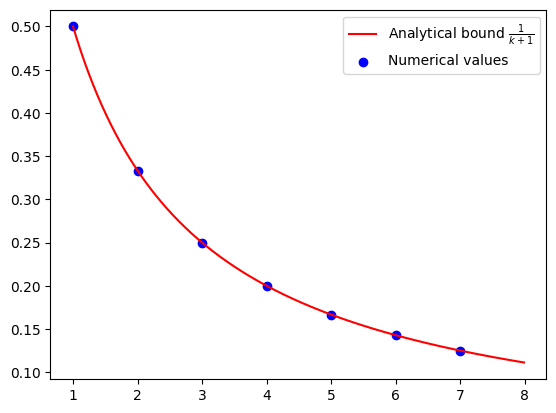

In [5]:
N = 8
alpha = pf.Parameter("alpha")
R = pf.Parameter("R")
alpha_value = 1
R_value = 1

opt_values = []

for k in range(1, N):
    ctx_plt = make_ctx_drs(ctx_name=f"ctx_plt_{k}", N=k, stepsize=alpha)
    pb_plt = make_pb_drs(ctx_plt, alpha, R)
    result = pb_plt.solve(resolve_parameters={"alpha": alpha_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    1 / (cont_iters + 1),
    "r-",
    label="Analytical bound $\\frac{1}{k+1}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of DRS

In [6]:
N = sp.S(2)
alpha_value = sp.S(1)
R_value = sp.S(1)

ctx_prf = make_ctx_drs(ctx_name="ctx_prf", N=N, stepsize=alpha)
pb_prf = make_pb_drs(ctx_prf, alpha, R)

result = pb_prf.solve(resolve_parameters={"alpha": alpha_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variables associated with the interpolations conditions of g with no relaxation
gamm_dense = result.get_scalar_constraint_dual_value_in_numpy(g)

0.3333323794791133


In [7]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"alpha": alpha_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


### Solve the problem again with the found relaxation

In [8]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_{n} as "n-1".
    We index "x_avg" as "N" where N is the last iterate.
    We index "x_tilde" as "N+1" where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx) - 1
    elif idx == "{{avg}}":
        return N
    elif idx == "{{tilde}}":
        return N + 1

In [9]:
relaxed_constraints = []

for tag_i in lamb_dense.row_names:
    i = tag_to_index(tag_i)
    for tag_j in lamb_dense.col_names:
        j = tag_to_index(tag_j)
        if i == N + 1 and j in range(N):
            continue
        if i in range(N) and j == N:
            continue
        relaxed_constraints.append(f"f:{tag_i},{tag_j}")

for tag_i in gamm_dense.row_names:
    i = tag_to_index(tag_i)
    for tag_j in gamm_dense.col_names:
        j = tag_to_index(tag_j)
        if i == N and j in range(N):
            continue
        if i in range(N) and j == N + 1:
            continue
        relaxed_constraints.append(f"g:{tag_i},{tag_j}")

pb_prf.set_relaxed_constraints(relaxed_constraints)

In [10]:
result = pb_prf.solve(resolve_parameters={"alpha": alpha_value, "R": R_value})

# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the interpolations conditions of g
gamm_sol = result.get_scalar_constraint_dual_value_in_numpy(g)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

- Print the values of $\lambda$ obtained from the solver

In [11]:
lamb_sol.pprint()

<IPython.core.display.Math object>

In [12]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1 and j in range(N):
        return 1 / N
    if i in range(N) and j == N:
        return 1 / N
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [13]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of lambda? True


## Verify closed form expression of $\gamma$

- Print the values of $\gamma$ obtained from the solver

In [14]:
gamm_sol.pprint()

<IPython.core.display.Math object>

In [15]:
# We consider proper shifting since x_0 is not in the gamma matrix
def gamm(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N and j in range(N):
        return 1 / N
    if i in range(N) and j == N + 1:
        return 1 / N
    return 0


gamm_cand = pf.pprint_labeled_matrix(
    gamm, gamm_sol.row_names, gamm_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

In [16]:
print(
    "Did we guess the right closed form of gamma?",
    np.allclose(gamm_sol.matrix, gamm_cand, atol=1e-4),
)

Did we guess the right closed form of gamma? True


## Verify closed form expression $S$

- Create an ExpressionManager to translate $x_i$, $f(x_i)$, and $\nabla f(x_i)$ into a basis representation

In [17]:
pm = pf.ExpressionManager(
    ctx_prf, resolve_parameters={"alpha": alpha_value, "R": R_value}
)

- Print the values of $S$ obtained from the solver

In [18]:
S_sol.pprint()

<IPython.core.display.Math object>

- Subtract the decomposed closed-form expressions

In [19]:
x = ctx_prf.tracked_point(f)
p = ctx_prf.tracked_point(g)
u = [ctx_prf[f"u_{i}"] for i in range(1, N + 1)]
v = [f.grad(x[i]) + u[i] for i in range(N)]

x_0 = ctx_prf["x_0"]
x_tilde = ctx_prf["x_{{tilde}}"]
u_0 = ctx_prf["u_0"]
u_tilde = ctx_prf["u_{{tilde}}"]

In [20]:
print(x)
print(p)
print(u)

[x_1, x_2, x_{{avg}}, x_{{tilde}}]
[p_1, p_2, p_{{avg}}, p_{{tilde}}]
[u_1, u_2]


In [21]:
S_guess1_x = (
    1
    / (alpha * (N + 1))
    * (x_0 - x_tilde - alpha * (N + 1) / (2 * N) * sum(v[i] for i in range(N))) ** 2
)
S_guess1_u = (
    alpha
    / (N + 1)
    * (u_0 - u_tilde + (N + 1) / (2 * N) * sum(v[i] for i in range(N))) ** 2
)

remainder1 = S_sol.matrix - pm.eval_scalar(S_guess1_x + S_guess1_u).inner_prod_coords
pf.pprint_labeled_matrix(remainder1, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [22]:
S_guess2 = (
    alpha
    / (4 * N**2)
    * sum((v[i] - v[j]) ** 2 for i, j in itertools.product(range(N), range(N)))
)

remainder2 = remainder1 - pm.eval_scalar(S_guess2).inner_prod_coords
pf.pprint_labeled_matrix(remainder2, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

- Check whether our candidate of $S$ matches with solution

In [23]:
S_guess = S_guess1_x + S_guess1_u + S_guess2
S_guess_eval = pm.eval_scalar(S_guess).inner_prod_coords
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [24]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(S_guess_eval, S_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of S? True


### Symbolic calculation

- Assemble the RHS of the proof.

In [25]:
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(ctx_prf.tracked_point(f), ctx_prf.tracked_point(f)):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_0-alpha*u_0))+grad_f(x_{{avg}})*(x_1-x_{{avg}}))+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_1-alpha*(u_1)))+grad_f(x_{{avg}})*(x_2-x_{{avg}}))+1/2*(f(prox_{alpha*f}(x_0-alpha*u_0))-f(x_{{tilde}})+grad_f(x_1)*(x_{{tilde}}-(x_1)))+1/2*(f(prox_{alpha*f}(x_1-alpha*(u_1)))-f(x_{{tilde}})+grad_f(x_2)*(x_{{tilde}}-(x_2)))

In [26]:
for x_i, x_j in itertools.product(ctx_prf.tracked_point(g), ctx_prf.tracked_point(g)):
    if gamm(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += gamm(x_i.tag, x_j.tag) * g.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_0-alpha*u_0))+grad_f(x_{{avg}})*(x_1-x_{{avg}}))+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_1-alpha*(u_1)))+grad_f(x_{{avg}})*(x_2-x_{{avg}}))+1/2*(f(prox_{alpha*f}(x_0-alpha*u_0))-f(x_{{tilde}})+grad_f(x_1)*(x_{{tilde}}-(x_1)))+1/2*(f(prox_{alpha*f}(x_1-alpha*(u_1)))-f(x_{{tilde}})+grad_f(x_2)*(x_{{tilde}}-(x_2)))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))+u_{{tilde}}*(p_1-p_{{tilde}}))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))+u_{{tilde}}*(p_2-p_{{tilde}}))+1/2*(g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))-g(p_{{avg}})+grad_g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))*(p_{{avg}}-(p_1)))+1/2*(g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))-g(p_{{avg}})+grad_g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))*(p_{{avg}}-(p_2)))

In [27]:
RHS = interp_scalar_sum - S_guess
display(RHS)

0+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_0-alpha*u_0))+grad_f(x_{{avg}})*(x_1-x_{{avg}}))+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_1-alpha*(u_1)))+grad_f(x_{{avg}})*(x_2-x_{{avg}}))+1/2*(f(prox_{alpha*f}(x_0-alpha*u_0))-f(x_{{tilde}})+grad_f(x_1)*(x_{{tilde}}-(x_1)))+1/2*(f(prox_{alpha*f}(x_1-alpha*(u_1)))-f(x_{{tilde}})+grad_f(x_2)*(x_{{tilde}}-(x_2)))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))+u_{{tilde}}*(p_1-p_{{tilde}}))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))+u_{{tilde}}*(p_2-p_{{tilde}}))+1/2*(g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))-g(p_{{avg}})+grad_g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))*(p_{{avg}}-(p_1)))+1/2*(g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))-g(p_{{avg}})+grad_g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))*(p_{{avg}}-(p_2)))-(1/alpha*3*|x_0-x_{{tilde}}-alpha*3/4*(grad_f(x_1)+u_1+grad_f(x_2)+u_2)|^2+alpha/3*|u_0-u_{{tilde}}+3/4*(grad_f(x_1)+u_1+grad_f(x_2)+u_2)|^2

- Assemble the LHS of the proof

In [28]:
x_avg = ctx_prf["x_{{avg}}"]
u_avg = ctx_prf["u_{{avg}}"]
p_avg = ctx_prf["p_{{avg}}"]
p_tilde = ctx_prf["p_{{tilde}}"]

perf_metric = (
    f(x_avg)
    - f(x_tilde)
    + g(p_tilde)
    - g(p_avg)
    + u_tilde * x_avg
    - u_tilde * p_tilde
    - u_avg * x_tilde
    + u_avg * p_avg
)
LHS = perf_metric - 1 / (alpha * (N + 1)) * (
    (x_0 - x_tilde) ** 2 + alpha**2 * (u_0 - u_tilde) ** 2
)

In [29]:
diff = LHS - RHS
display(diff)

f(x_{{avg}})-f(x_{{tilde}})+g(p_{{tilde}})-g(p_{{avg}})+u_{{tilde}}*x_{{avg}}-u_{{tilde}}*p_{{tilde}}-u_{{avg}}*x_{{tilde}}+u_{{avg}}*p_{{avg}}-1/alpha*3*(|x_0-x_{{tilde}}|^2+alpha**2*|u_0-u_{{tilde}}|^2)-(0+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_0-alpha*u_0))+grad_f(x_{{avg}})*(x_1-x_{{avg}}))+1/2*(f(x_{{avg}})-f(prox_{alpha*f}(x_1-alpha*(u_1)))+grad_f(x_{{avg}})*(x_2-x_{{avg}}))+1/2*(f(prox_{alpha*f}(x_0-alpha*u_0))-f(x_{{tilde}})+grad_f(x_1)*(x_{{tilde}}-(x_1)))+1/2*(f(prox_{alpha*f}(x_1-alpha*(u_1)))-f(x_{{tilde}})+grad_f(x_2)*(x_{{tilde}}-(x_2)))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))+u_{{tilde}}*(p_1-p_{{tilde}}))+1/2*(g(p_{{tilde}})-g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))+u_{{tilde}}*(p_2-p_{{tilde}}))+1/2*(g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))-g(p_{{avg}})+grad_g(prox_{alpha*g}(alpha*(u_0+1/alpha*(2*(x_1)-x_0))))*(p_{{avg}}-(p_1)))+1/2*(g(prox_{alpha*g}(alpha*(u_1+1/alpha*(2*(x_2)-(x_1)))))-g(p_{{avg}})+grad_g(prox_{

In [30]:
pf.pprint_str(
    diff.repr_by_basis(
        ctx_prf,
        sympy_mode=True,
        resolve_parameters={"alpha": alpha_value, "R": R_value},
    )
)

<IPython.core.display.Math object>

---

#### With the verified closed form expression, we have verified the below for fixed $N$

\begin{align*}
&\mathcal{L}(\bar{x}^N, \tilde{u}) - \mathcal{L}(\tilde{x}, \bar{u}^N) 
- \frac{1}{\alpha (N+1)} \left( \|x^0 - \tilde{x}\|^2 + \alpha^2 \|u^0 - \tilde{u}\|^2 \right) \\ 
&= \frac{1}{N} \sum_{k=1}^N 
\Big( f(\bar{x}^N) - f(x^k) + 
\big\langle \tilde{\nabla} f(\bar{x}^N), x^k - \bar{x}^N \big\rangle \Big)
+ \frac{1}{N} \sum_{k=1}^N 
\Big( f(x^k) - f(\tilde{x}) + 
\big\langle \tilde{\nabla} f(x^k), \tilde{x} - x^k \big\rangle \Big)\\
& + \frac{1}{N} \sum_{k=1}^N 
\Big( g(p^k) - g(\bar{p}^N) + 
\big\langle u^k, \bar{p}^N - p^k \big\rangle \Big)
+ \frac{1}{N} \sum_{k=1}^N 
\Big( g(\tilde{p}) - g(p^k) + 
\big\langle \tilde{u}, p^k - \tilde{p} \big\rangle \Big) \\
& + \frac{1}{\alpha (N+1)} 
\left( 
\left\| x^0 - \tilde{x} - \frac{\alpha (N+1)}{2N} \sum_{k=1}^N v^k \right\|^2
+ \alpha^2 
\left\| u^0 - \tilde{u} - \frac{N+1}{2N} \sum_{k=1}^N v^k \right\|^2
\right) \\
& + \frac{\alpha}{2N^2} 
\sum_{k=1}^N \sum_{l=1}^{k-1} 
\|v^k - v^l\|^2
\end{align*}
holds, where we denote $v^k = \tilde{\nabla} f(x^k) + u^k$.